<a href="https://colab.research.google.com/github/rinazbelhaj/EIP/blob/master/Assignment%205/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing and unzipping data on local drive

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
!ls

--2019-07-12 16:22:48--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.6MB/s    in 14s     

2019-07-12 16:23:03 (16.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

gdrive	sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


# Data Import Function

## Augmentations Used:


1.   Shear
2.   Zoom
3.   Image Rotation
4.   Horizontal flip
5.   Vertical flip
6.   Random masking of 6.25% of image



In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping

def mask_func(image):
    img_size = image.shape[0]
    low = np.random.randint(0,img_size-img_size/4)
    high = low + img_size//4
    image[:][low:high,low:high] = 0
    return image

def data_load(batch_size,img_size,aug=False):
  # Use Augmentaion parameters as required.
  if aug:
    print("Using Image Augmentation")
    train_datagen = ImageDataGenerator(rescale= 1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=90,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       preprocessing_function=mask_func)
  else:
    print("Not Using Image Augmentation")
    train_datagen = ImageDataGenerator(rescale= 1./255)

  valid_datagen = ImageDataGenerator(rescale=1./255)
  train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(img_size, img_size), color_mode='rgb', 
                                                      batch_size=batch_size, class_mode='categorical', shuffle=True, seed=42)
  val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
  val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)

  validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', 
                                                           target_size=(64, 64), color_mode='rgb', class_mode='categorical',
                                                           batch_size=batch_size, shuffle=True, seed=42)
  return train_generator,validation_generator

Using TensorFlow backend.


# Loading Pretrained Model

In [3]:
from keras.models import load_model
import math

model = load_model('gdrive/My Drive/Data/EIP/resnet_4_3_105.h5') 

train_generator,validation_generator = data_load(batch_size=10000,img_size=64)
X_Val, Y_Val = validation_generator.next()
print(X_Val.shape,Y_Val.shape)

score = model.evaluate(X_Val, Y_Val, verbose=1)
print(score)



W0712 19:59:13.009320 139627995625344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 19:59:13.036018 139627995625344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0712 19:59:13.072793 139627995625344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 19:59:13.074010 139627995625344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 19:59:13.07532

Not Using Image Augmentation
Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
(10000, 64, 64, 3) (10000, 200)
10000/10000 [==============================] - 69s 7ms/step
[2.0990601104736326, 0.6024]


# Predicting and Identifying Misclassified Images

In [4]:
pred_val = model.predict(X_Val, batch_size=None, verbose=0, steps=None)
results = pd.DataFrame({'Actual':Y_Val.argmax(axis=-1),'Predicted':pred_val.argmax(axis=-1)})
results['Image_No'] = results.index
lookup = pd.DataFrame(list((validation_generator.class_indices).items()), columns=['Label', 'Dummy'])
label_code = results.merge(lookup, left_on='Actual', right_on='Dummy')
label_code = label_code[["Image_No","Actual", "Predicted","Label"]]
label_code.columns = ["Image_No","Actual", "Predicted","Label_Actual"]

label_code = label_code.merge(lookup, left_on='Predicted', right_on='Dummy')
label_code = label_code[["Image_No","Actual", "Predicted","Label_Actual","Label"]]
label_code.columns = ["Image_No","Actual", "Predicted","Label_Actual","Label_Predicted"]


label_name = pd.read_csv("tiny-imagenet-200/words.txt", sep="\t", header=None)
label_name.columns = ["Label", "Desc"]
label_name["class"] = label_name["Desc"].str.split(",", n = 1, expand = True)[0]

label_name = label_name[["Label","class"]]

final = label_code.merge(label_name, left_on='Label_Actual', right_on='Label')
final = final[["Image_No","Actual", "Predicted","Label_Actual","Label_Predicted","class"]]
final.columns = ["Image_No","Actual", "Predicted","Label_Actual","Label_Predicted","Class_Actual"]

final = final.merge(label_name, left_on='Label_Predicted', right_on='Label')
final = final[["Image_No","Actual", "Predicted","Label_Actual","Label_Predicted","Class_Actual","class"]]
final.columns = ["Image_No","Actual", "Predicted","Label_Actual","Label_Predicted","Class_Actual","Class_Predicted"]
final = final.sort_values("Image_No")

misclass = final[final['Actual'] != final['Predicted']]

Class_Actual = list(misclass['Class_Actual']) 
Class_Predicted = list(misclass['Class_Predicted']) 
image_index = list(misclass['Image_No'])

misclass.head(10)

,Image_No,Actual,Predicted,Label_Actual,Label_Predicted,Class_Actual,Class_Predicted
0,0,41,188,n02233338,n07753592,cockroach,banana
7370,1,75,143,n02841315,n04118538,binoculars,rugby ball
982,2,99,18,n03250847,n01983481,drumstick,American lobster
9454,3,30,28,n02123045,n02106662,tabby,German shepherd
7420,4,37,95,n02190166,n03126707,fly,crane
5354,7,150,105,n04259630,n03404251,sombrero,fur coat
5704,9,74,158,n02837789,n04371430,bikini,swimming trunks
7797,10,132,157,n03976657,n04366367,pole,suspension bridge
6145,13,148,138,n04251144,n04023962,snorkel,punching bag
1235,15,37,4,n02190166,n01698640,fly,American alligator


# GradCam Function

In [0]:
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2



def gradCam(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  pred_val = model.predict(x, batch_size=None, verbose=0, steps=None)
  class_idx = np.argmax(pred_val[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_423")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  pooled_grads
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(last_conv_layer.filters):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  heatmap = heatmap.astype(dtype=np.float32)/255

  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

  return superimposed_img

# Image Gallery Function

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(image,Class_Actual,Class_Predicted,grad=False):
  fig = plt.figure(figsize=(19, 8))
  columns = 5
  rows = 2

  # ax enables access to manipulate each of subplots
  ax = []

  for i in range(columns*rows):
      img = image[i]
      # create subplot and append to ax
      ax.append( fig.add_subplot(rows, columns, i+1) )
      ax[-1].set_title("Actual : "+Class_Actual[i]+" \nPredicted : "+Class_Predicted[i])  # set title
      if grad:
        plt.imshow(gradCam(img))
      else:
        plt.imshow(img)

  plt.show()  # finally, render the plot

# Original Image and Grad Cam Results

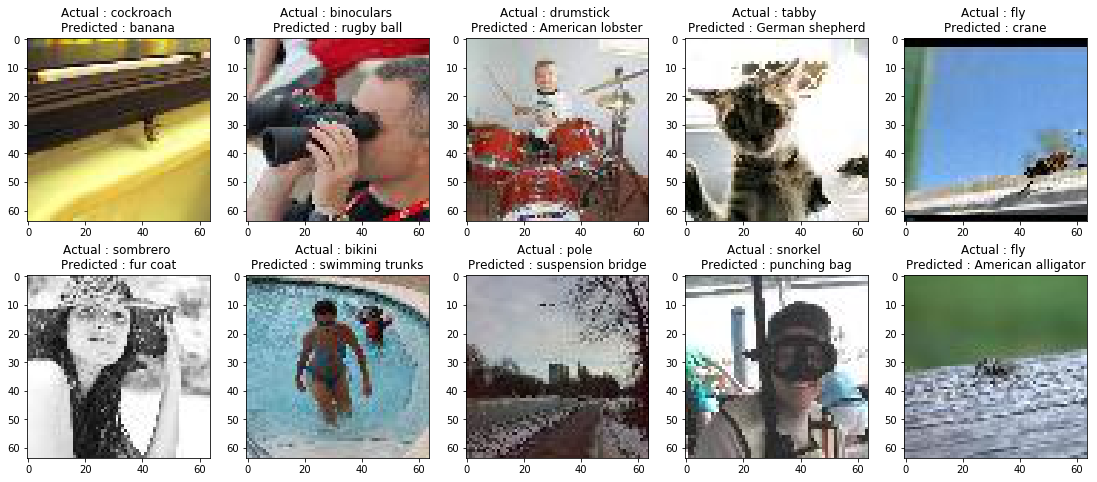

In [11]:
misimage = X_Val[image_index]
plot_images(misimage,Class_Actual,Class_Predicted,grad=False)

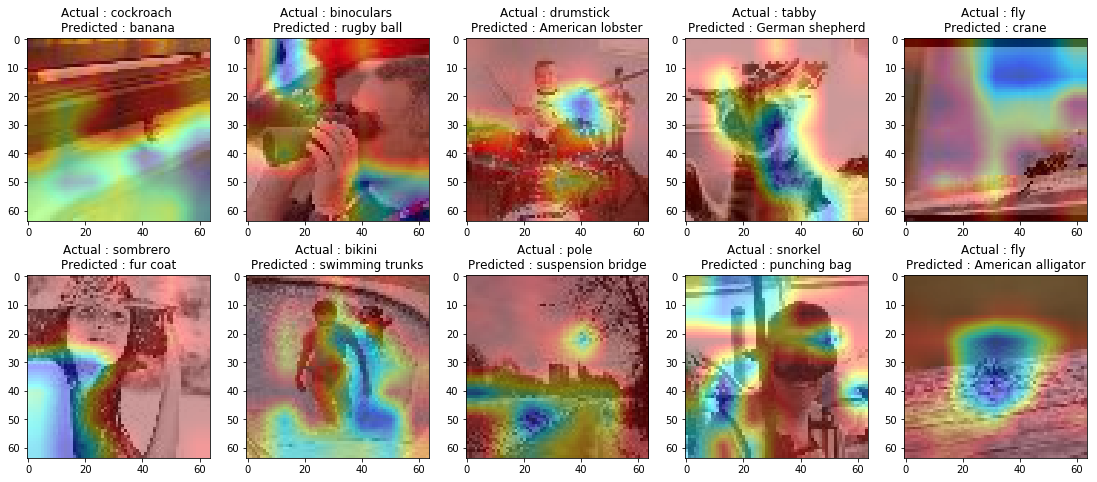

In [12]:
plot_images(misimage,Class_Actual,Class_Predicted,grad=True)

# Where CNN is looking

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(image,Class_Actual,Class_Predicted,grad=False):
  fig = plt.figure(figsize=(10, 300))
  columns = 2
  max_obs = 50

  # ax enables access to manipulate each of subplots
  ax = []
  
  even_range = [n for n in range(max_obs*columns) if n % 2 == 0]

  for k in even_range:
    i = k//2
    img = image[i]
    # create subplot and append to ax
    ax.append( fig.add_subplot(max_obs, columns, k+1) )
    ax[-1].set_title("Actual : "+Class_Actual[i]+" \nPredicted : "+Class_Predicted[i])  # set title
    plt.imshow(img)
    ax.append( fig.add_subplot(max_obs, columns, k+2) )
    ax[-1].set_title("Actual : "+Class_Actual[i]+" \nPredicted : "+Class_Predicted[i])  # set title
    plt.imshow(gradCam(img))
      

  plt.show()  # finally, render the plot

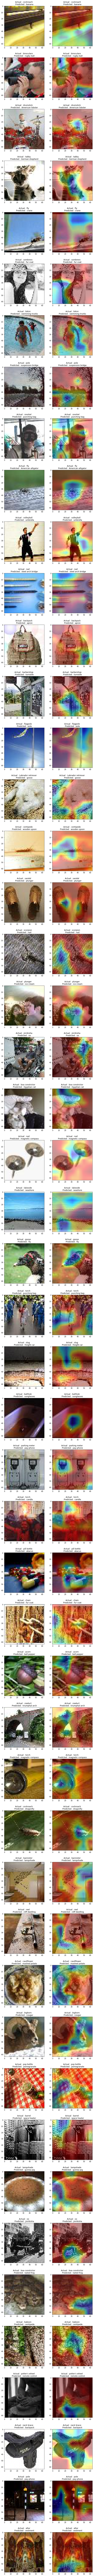

In [15]:
misimage = X_Val[image_index]
plot_images(misimage,Class_Actual,Class_Predicted,grad=False)